## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [1]:
import pandas as pd
import numpy as np

datafile_path = "https://cdn.openai.com/API/examples/data/fine_food_reviews_with_embeddings_1k.csv"  # for your convenience, we precomputed the embeddings
df = pd.read_csv(datafile_path)
df["babbage_similarity"] = df.babbage_similarity.apply(eval).apply(np.array)
matrix = np.vstack(df.babbage_similarity.values)
matrix.shape


(1000, 2048)

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [2]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


Cluster
2    2.543478
3    4.374046
0    4.709402
1    4.832099
Name: Score, dtype: float64

It looks like cluster 2 focused on negative reviews, while cluster 0 and 1 focused on positive reviews.

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

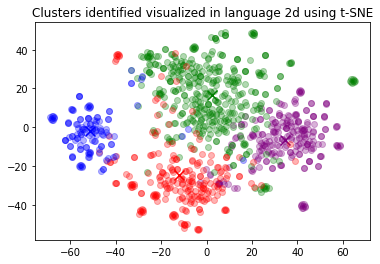

In [3]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. The red cluster clearly represents negative reviews. The blue cluster seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use davinci-instruct-beta-v3 to name the clusters, based on a random sample of 6 reviews from that cluster.

In [4]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 3

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="davinci-instruct-beta-v3",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme:  All of the customer reviews mention the great flavor of the product.
5, French Vanilla Cappuccino:   Great price.  Really love the the flavor.  No need to add anything to 
5, great coffee:   A bit pricey once you add the S & H but this is one of the best flavor
5, Love It:   First let me say I'm new to drinking tea. So you're not getting a well
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  All three reviews mention the quality of the product.
5, Beautiful:   I don't plan to grind these, have plenty other peppers for that.  I go
5, Awesome:   I can't find this in the stores and thought I would like it.  So I bou
5, Came as expected:   It was tasty and fresh. The other one I bought was old and tasted mold
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  All reviews are about customer's disappointment.
1, Disappointed...:   I shou

We can see based on the average ratings per cluster, that Cluster 2 contains mostly negative reviews. Cluster 0 and 1 contain mostly positive reviews, whilst Cluster 3 appears to contain reviews about dog products.

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.